## Introduction to normalizing flows

In *latent variable inference*, our goal is to learn a distribution $p(Z,X)$ where $X \in \mathbb{R}^d$ is our observations and $Z \in \mathbb{R}^m$ is some set of latent variables sampled from a known or unknown distribution. Notice that, from the definition of conditional probability, we get:

$$
p(Z|X) = \frac{p(Z,X)}{p(X)}
$$

where $p(Z|X)$ can be viewed as our *posterior distribution* over the latent variables, given the data. From Bayes rule, we get:

$$
p(Z|X) \propto p(X|Z)p(Z)
$$

where $p(X|Z)$ is the *likelihood* of our data given some set of latent variables, and $p(Z)$ is the *prior distribution* over the latent variables $Z$. Since $Z$ is unobserved, we can assume $p(Z)$ to be whatever we want (within reason); the most common choice is to let $Z \sim \mathcal{N}(\mu,\sigma)$. This is often called Gaussian factorization, since we're essentially assuming that our data can be factorized into a set of independent Gaussian variables.

Now comes the tricky part: how do we choose our likelihood function, $p(X|Z)$? Unless we know a lot about data beforehand, it's usually safe to assume that the posterior $p(Z|X)$ is probably quite complex. For example, it very well might follow a multi-modal or even non-normal density. Traditional Bayesian inference methods build a likelihood function from hierarchical priors and use sampling methods like Metropolis-Hastings or Hamiltonian Monte-Carlo to implicitly sample from the posterior density.

But what if we're dealing with high dimensional data? For images, audio, or any kind of complex spatio-temporal data, $d$ and $m$ may be on the order of ten or a hundred thousand (possibly even millions!).

*Variational inference* instead attempts to approximate $p(Z | X)$ by constructing a lower bound on the log marginal likelihood, $p(X)$. This is done using a known, tractable *variational distribution* $q(Z)$. The goal is then to minimize the dissimilarity between $p(Z | X)$ and the chosen variational distribution $q(Z)$.

#### The variational lower bound

The variational or evidence lower bound (ELBO) is defined as

$$
\begin{align*}
\log p_\theta(X) &\geq \log p_\theta(X) - \text{KL}\big [q(Z|X) || p_\theta(Z|X)\big ] \\
                 & = \underset{q}{\mathbb{E}}\big [ \log p_\theta(X|Z)\big ] -
                 \text{KL}\big [ q(Z|X) || p(Z) \big] \\
                 & = \text{ELBO}_{\theta}(p,q) \\
                 & = -\mathcal{F}_{\theta}(p,q)
\end{align*}
$$

where $\theta$ are the model parameters, $\text{KL}\big [q||p\big] = \mathbb{E}_x\big [\log\frac{q(x)}{p(x)}\big]$ is the Kullback-Leibler divergence between distributions $p$ and $q$, and $\mathcal{F}$ is called the *variational free energy*. The first term, $\underset{q}{\mathbb{E}}\big [ \log p_\theta(X|Z)\big ]$ is simply the log likelihood of the data given $\theta$ and $Z$. The $\text{KL}$ term acts as a kind of *regularizer* forcing the variational approximation $q(Z|X)$ to stay as close as possible to the prior $p(Z)$.

#### Improved variational approximations

For simple choices of $q$, most commonly an isotropic Gaussian, the ELBO will be very loose, resulting a poor approximation of the posterior. Rezende and Mohamed (2015) showed that our variational or "surrogate" posterior $q$ can be improved using *normalizing flows*.

Let $z \sim p(Z)$ be a random variable sampled from our latent space, $Z$. Let $f$ be an *invertible* function such that $z = f^{-1}(f(z))$. Let $z' = f(z)$. Then the density of $z'$ can be represented as:

$$
p(z') = p(z)|\det{\mathbb{J}_{f^{-1}}(z')}| = p(z)|\det{\mathbb{J}_f(z)}|^{-1}
$$

where $\mathbb{J}_f$ represents the Jacobian of $f$ with respect to the given variable. We can chain multiple invertible functions $f_i$ together:

$$
z_k = f_k \circ f_{k-1} \circ \cdots \circ f_1(z_0)
$$

The resulting transformation of variables $z_0,\dots,z_k$ is called a *flow*. The log density of $z_k$ is then computed as:

$$
\log p_k(z_k) = \log p_0(z_0) + \sum_{i=1}^k{\log |\det{\mathbb{J}_{f_{i}}(z_{i-1})}}|^{-1}
$$

So what's the point of all of this? Remember that we're trying to approximate $p(Z|X)$. We can think of each $f_i$ as some invertible operation which expands, contracts, or cuts the space of $z_i$ in order to make $p(z_k)$ as similar as possible (ideally equivalent) to the true posterior $p(Z|X)$. A flow of arbitrary length and complexity can potentially represent arbitrarily complex (and possibly multi-modal!) distributions. 

### Normalizing flows: A demo

Let's try to make this more concrete. We'll consider a simple example with a 2D parabolic target distribution.

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
from normalizing_flows.flows import Flow, affine
from normalizing_flows.models.losses import kl_divergence_normal
from tqdm import tqdm

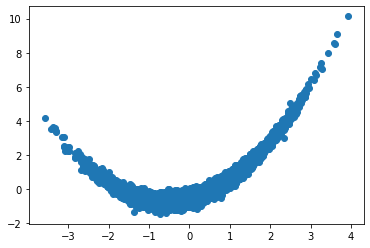

In [2]:
def sample_target(n):
    x1 = tf.random.normal((n,1), mean=2.5, stddev=5.2)
    x2 = tf.random.normal((n,1), mean=x1 + x1**2, stddev=10.)
    x = tf.concat([x1,x2],axis=1)
    # rescale
    x = (x - tf.math.reduce_mean(x, axis=0))/tf.math.reduce_std(x, axis=0)
    return x

N = 10000
x_target = sample_target(N)
# plot
_ = plt.scatter(x_target[:,0], x_target[:,1])

We'll start by using normalizing flows to improve vanilla, *mean field* variational inference, where a Gaussian is fit to each data point.

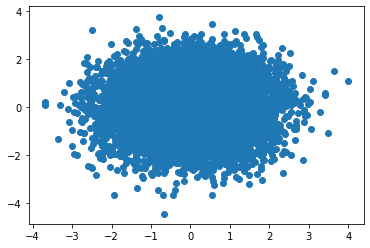

In [3]:
variational_mean = tf.Variable(tf.zeros((N,2)))
variational_log_scale = tf.Variable(tf.zeros((N,2)))
variational_density = tfp.distributions.MultivariateNormalDiag(
    loc=variational_mean,
    scale_diag=tfp.util.DeferredTensor(variational_log_scale, tf.math.exp),
)
samples = variational_density.sample()
_ = plt.scatter(samples[:,0], samples[:,1])

We'll create a simple *planar flow* (Rezende and Mohamed, 2015), where each step is defined as:

$$
f'(\mathbf{z}) = z + \mathbf{u}^{T} h'(\mathbf{w}^\intercal\mathbf{z} + b)\mathbf{w}
$$

and the Jacobian determinant is given by:

$$
|\det\mathbb{J}_f(\mathbf{z})| = |1 + \mathbf{u}^\intercal f'(\mathbf{z})|
$$

This is analagous to a 1-dimensional generalized linear model (GLM) or a single neuron in a neural network.

**Note**: Planar flows are "invertible" in the strictest mathematical sense, but not in practice. This is largely due to the residual term.

In [4]:
# construct planar flow
num_steps = 4
flow = Flow.uniform(num_steps, lambda i: affine.Planar())
# create trainable parameters;
# planar flow requires parameters to be given on the forward pass
flow_params = flow.create_variables(x_target.shape)

Finally, we train our flow by minimizng the variational free energy (equivalent to *maximizing* the ELBO). We use mean squared error as a surrogate for the negative log likelihood. We use the standard normal $\mathcal{N}(0,\mathbb{I})$ as the latent prior.

**Note**: For flows with a tractable inverse, the NLL can be computed as $p_z(f^{-1}(x))$ where $p_z$ is the density over $Z$.

In [5]:
# MLE training
trainable_variables = [variational_mean,variational_log_scale,*flow_params]
optimizer = tf.keras.optimizers.Adam(lr=1.0E-2, amsgrad=True)
N_iter = 400
with tqdm(total=N_iter) as prog:
    for i in range(N_iter):
        with tf.GradientTape() as gt:
            x_0 = variational_density.sample()
            x_k, ldj = flow(x_0, *flow_params)
            # use MSE as negative log likelihood estimate
            nll = tf.math.reduce_mean((x_k - x_target)**2)
            # compute the KL divergence analytically between
            # our initial variational density and the standard normal (prior)
            kld = kl_divergence_normal(x_0, x_k,
                                       variational_mean,
                                       0.0,
                                       variational_log_scale,
                                       0.0,
                                       ldj=ldj)
            # loss is NLL + the scaled KL divergence;
            # KLD is annealed to prevent early collapse to the prior density
            loss = nll + 1.0/(N_iter-i+1.)*kld
        grads = gt.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(grads,trainable_variables))
        prog.update(1)
        prog.set_postfix({'loss': loss.numpy(), 'mse': nll.numpy()})

100%|██████████| 400/400 [02:22<00:00,  2.80it/s, loss=1.16, mse=0.112] 


We can visualize the learned distribution by sampling from the learned initial density and then evaluating each step of the flow. The following plot shows the iniital density (left) and then each subsequent density after every step of the planar flow. The last (right most) plot shows the final learned density.

Notice how the vanilla variational approximation is very loose with far more vertical spread than the true posterior. The normalizing flow is able to ameliorate this through a series of simple transformations.

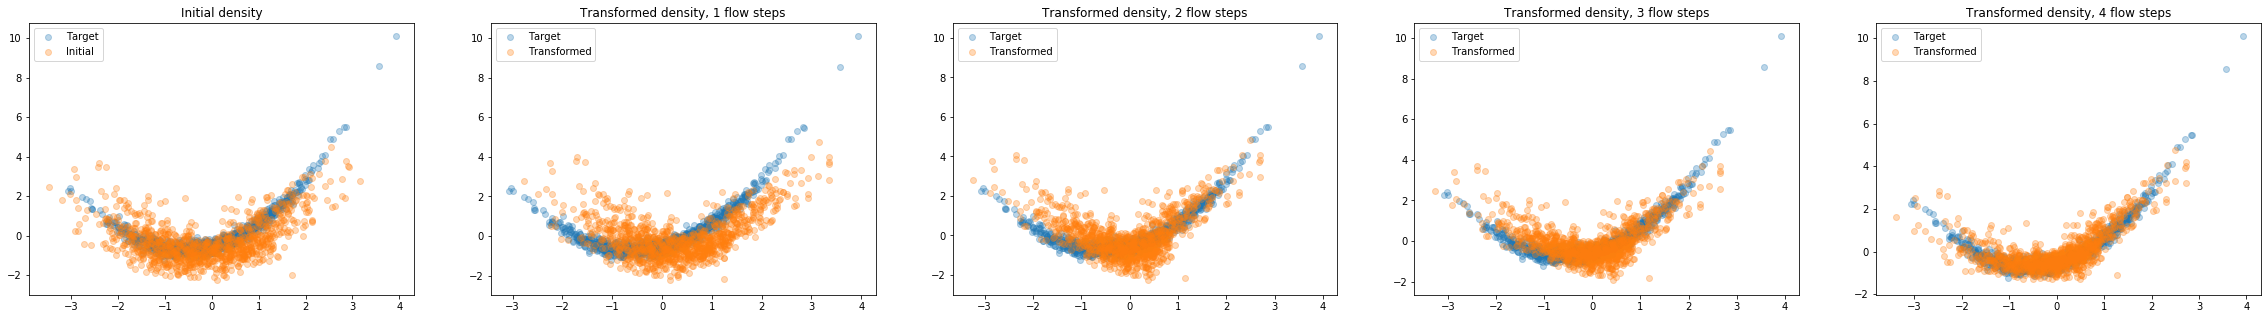

In [6]:
x_0 = variational_density.sample()
xs, ldj = flow(x_0, *flow_params, return_sequence=True)
fig, axs = plt.subplots(1, 5, figsize=(8*5,5))
axs[0].scatter(x_target[::10,0],x_target[::10,1],alpha=0.3)
axs[0].scatter(xs[0][::10,0],xs[0][::10,1],alpha=0.3)
axs[0].legend(['Target', 'Initial'])
axs[0].set_title('Initial density')
for i in range(1,5):
    axs[i].scatter(x_target[::10,0],x_target[::10,1],alpha=0.3)
    axs[i].scatter(xs[i][::10,0],xs[i][::10,1],alpha=0.3)
    axs[i].legend(['Target', 'Transformed'])
    axs[i].set_title(f'Transformed density, {i} flow steps')

This looks prety good! However, there is one major problem with this approach: it doesn't scale. We had to train variational parameters for *all 10,000 data points*. That's a lot of parameters!

But what if we have hundreds of thousands or millions of data points? What if our data is high dimensional? Or perhaps even more simply, what if we don't always have *exactly* `N` data points available at test time?

To solve these problems, we turn to *amortized* variational inference. In AVI, we use an *inference function* to generate our variational parameters (in this case, $\mu_i, \sigma_i$). We can also amortize the parameters to our flow, as suggested by Rezende and Mohamed.

One common amortization strategy is to leverage the expressive power of deep neural networks as our inference functions. These are often called *inference networks* or *encoders* in the language of variational autoencoders (Kingma et al. 2013).

The `normalizing_flows` package provides seemless integration with Keras via `FlowLayer`. We can use this to build a simple inference network for the same example.

In [7]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras import Model
from normalizing_flows.layers import FlowLayer
# resample x_target with more data points
N = 100000
n_epochs = 5
batch_size = 100
x_target = sample_target(N)

In [8]:
input_0 = Input(shape=(2,))
h = Dense(32, activation='relu')(input_0)
h = Dense(16, activation='relu')(h)
mu = Dense(2)(h)
log_var = Dense(2)(h)
# we give FlowLayer our mu and log variance;
# KLD loss will be added automatically;
# since gradient updates are batched, we use 1/(number of batches) as KLD weight
flow_layer = FlowLayer(min_beta=1.0E-3)
zs,_,_ = flow_layer([mu, log_var])
model = Model(inputs=input_0, outputs=zs[-1])
model.compile(loss='mse', optimizer='adam', metrics=['mse'])

In [9]:
# use callback for annealing KLD weight (beta);
betas = np.linspace(1.0E-3, 1.0, n_epochs*N//batch_size)
def update_beta(batch, logs):
    flow_layer.set_beta(betas[batch])
callback = LambdaCallback(on_batch_end=update_beta)
model.fit(x_target, x_target, batch_size=batch_size, epochs=n_epochs, callbacks=[callback])

Train on 100000 samples
Epoch 1/5
100000/100000 [==============================] - 1s 14us/sample - loss: 0.4305 - mse: 0.2215
Epoch 2/5
100000/100000 [==============================] - 1s 10us/sample - loss: 0.3211 - mse: 0.1032
Epoch 3/5
100000/100000 [==============================] - 1s 10us/sample - loss: 0.3185 - mse: 0.1019
Epoch 4/5
100000/100000 [==============================] - 1s 10us/sample - loss: 0.3185 - mse: 0.1015
Epoch 5/5
100000/100000 [==============================] - 1s 10us/sample - loss: 0.3181 - mse: 0.1012


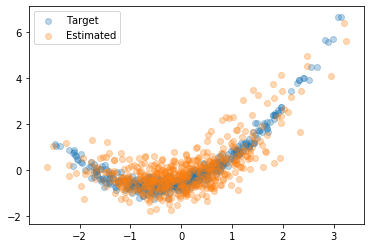

In [10]:
x_pred = model.predict(x_target)
plt.figure(figsize=(6,4))
plt.scatter(x_target[::200,0],x_target[::200,1],alpha=0.3)
plt.scatter(x_pred[::200,0], x_pred[::200,1],alpha=0.3)
_ = plt.legend(['Target', 'Estimated'])

This is a fairly easy problem, so we actually get a pretty good approximation with vanilla AVI. For the sake of demonstration, however, let's go ahead and add our planar flow. The main change is that we need an additional `Dense` layer to generate the flow parameters.

**Note**: The loss reported by Keras includes both the KL-divergence and MSE. This makes it somewhat difficult to use as a comparison between the two methods. Thus, we report MSE alone as a secondary metric.

In [11]:
input_0 = Input(shape=(2,))
h = Dense(32, activation='relu')(input_0)
h = Dense(16, activation='relu')(h)
mu = Dense(2)(h)
log_var = Dense(2)(h)
flow_params = Dense(flow.param_count((2,)))(h)
# we give FlowLayer our mu, log variance, and the amortized flow parameters;
# KLD loss will be added automatically
flow_layer = FlowLayer(flow, min_beta=1.0E-3)
zs,_,_ = flow_layer([mu, log_var, flow_params])
model = Model(inputs=input_0, outputs=zs[-1])
model.compile(loss='mse', optimizer='adam', metrics=['mse'])

In [12]:
# use callback for annealing KLD weight (beta);
betas = np.linspace(1.0E-3, 1.0, n_epochs*N//batch_size)
def update_beta(batch, logs):
    flow_layer.set_beta(betas[batch])
callback = LambdaCallback(on_batch_end=update_beta)
model.fit(x_target, x_target, batch_size=batch_size, epochs=n_epochs, callbacks=[callback])

Train on 100000 samples
Epoch 1/5
100000/100000 [==============================] - 2s 24us/sample - loss: 0.4400 - mse: 0.2078
Epoch 2/5
100000/100000 [==============================] - 1s 14us/sample - loss: 0.3424 - mse: 0.1204
Epoch 3/5
100000/100000 [==============================] - 1s 14us/sample - loss: 0.3311 - mse: 0.1097
Epoch 4/5
100000/100000 [==============================] - 1s 14us/sample - loss: 0.3271 - mse: 0.1058
Epoch 5/5
100000/100000 [==============================] - 1s 15us/sample - loss: 0.3243 - mse: 0.1044


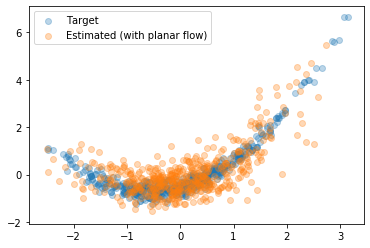

In [13]:
x_pred = model.predict(x_target)
plt.figure(figsize=(6,4))
plt.scatter(x_target[::200,0],x_target[::200,1],alpha=0.3)
plt.scatter(x_pred[::200,0], x_pred[::200,1],alpha=0.3)
_ = plt.legend(['Target', 'Estimated (with planar flow)'])

### Conclusion

While amortized variational inference is *theoretically* less expressive than the mean-field approximation (where every data point has its own variational parameters), it provides a much more favorable optimization objective. Thus, we often can still achieve comparable or even better performance. Notice also how we were able to obtain similar MSE in a fraction of the number of iterations!

While adding the planar flow in this case does not significantly change the MSE after 5 epochs, we can observe visually that the learned distribution is somewhat "tighter"; i.e. more closely grouped around the target. This is similar to what we observed before with mean-field VI.

However, we'll have to look at more complex, high dimensional target distributions to really see the power of normalizing flows.